In [111]:
#create a basic autoencoder, and create a build-train flow

### Building an Autoencoding Neural Network using $\texttt{pytorch}$

In this example tutorial, we will train our autoencoder on the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) of handwritten digits to reproduce these handwritten digits after passing them through a dimensionality reduction

An autoencoder is kind of neural network that takes input data, passes them through a bottleneck, and forces the output of the neural network to be equal to the input. If successful, the bottleneck is then a succesful low-dimensional representation of the input data, and the 'decoder' can be used to reproduce all of the information in the input data. 


The figure below shows how an autoencoder works. The original image is shown as input to the encoder. The pixels valuws are then encoded into progressively smaller layers, until the smallest layer, where all of the information is forced to pass through only 3 nodes. The decoder then maps the outputs of these 3 nodes to the original image. Once such an autoencoder is trained, the latent space of only three numbers can fully represent all information in the original data, and the decoder can "decode" the information in the three nodes to reproduce the original data.

![alt text](images/mona_lisa_AE.png)

### Let's build a simple autoencoder to show how this can work. 

First, let's take in our imports. We will use the $\texttt{pytorch}$ library, so we should make sure it is installed properly. We will also check if a GPU is available to us in this environment. If a GPU is available, we will do our training on the GPU. This will dramatically speed up our training period. However, if a GPU is unavailable, this notebook will know to just use the cpu for training. 

In [112]:
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import math

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on cpu")

Running on GPU


Let's now read in all the data. For the purpose of this tutorial, we will only train on a small fraction of the full dataset so the training process runs quickly enough that we can see it work. We will use only 1% of the full dataset, but feel free to experiment what happens when you use a larger fraction of the dataset.

In [113]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data", train = True, download = True, transform = tensor_transform)

# DataLoader is used to load the dataset 
# for training

indices6 = [i for i, (image, label) in enumerate(dataset) if label == 6]
only6_dataset = Subset(dataset, indices6)


subset_size = int(len(only6_dataset) * 0.1)  # 10% of the dataset of only 6's
indices_subset = np.random.choice(len(only6_dataset), size=subset_size, replace=False)

only6_subset_dataset = Subset(only6_dataset, indices_subset)
loader = torch.utils.data.DataLoader(dataset = only6_subset_dataset, batch_size = 60, shuffle = True)

Now that we have our data, let's build our neural network. The module $\texttt{pytorch}$ gives us almost complete flexibility in both how we build our neural network, including making very specific changes to the architecture or the training process of the neural network. 

For this example, let's build a neural network that can take in an image with dimension 28x28, and reduces it to a latent space with size 1, and then expands it back out to 28x28. It will do this over the course of 3 layers in each of the decoder and the encoder. The choice of using a latent space with size 1 is a special choice we're making here, and I'll comment on that in a little bit. 

In $\texttt{pytorch}$, a neural network like this is defined in a class. In our example, we are defining an autoencoder, so let's call our class 'AE':

In [118]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 1)
        )

        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1, 18),
            torch.nn.Sigmoid(),
            torch.nn.Linear(18, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Next, we need to define a loss function, an optimizer, and a training strategy. The loss function will be a function that measures how far off the predicted output from the neural network is from the required output. We will use the MSE (mean squared error) function to measure loss, a standard way to measure loss. It is given by this equation:


## MSE = $\frac{1}{N}\Sigma_{i=1}^{N}\left[y_i-y_i'\right]^2$,

where $y$ is the true data that the neural network is trying to fit to, and $y'$ is the value predicted by the neural network. Therefore, as the predicted value $y'$ comes closer to the true value $y$, the MSE is reduced. In the ideal case, $y'$ is exactly equal to $y$, and MSE equals 0. The module $\texttt{pytorch}$ is able to use the optimizer we define to get MSE to reduce to near zero. 
 

As such, the goal of our neural network is to work towards finding solutions that have progressively lower loss. The mathematical algorithm it will use to reduce loss is called the optimizer. We will use the [Adam optimizer](https://www.geeksforgeeks.org/adam-optimizer/), also a very commonly used optimizer.

Note that here we will take advantage of the GPU, if it's available. The GPU will be where the training process is done, so both the model and input data need to be cast onto the GPU. $\texttt{pytorch}$ treats (as it should!) the GPU and the CPU as two separate devices. As such, if we want to do computations with data on the GPU, everything interacting with the data and indeed, the data themselves, need to be cast onto the GPU. In the following cell, we will send both the model and data onto the GPU.


There's a function called plot_reconstructions, which will allow us to plot a reconstruction compared to an example image in the dataset at specific epochs that we'll decide. This function will take the original image, the reconstructed image, and the epoch at which this is done, will plot the image and reconstruction next to each other.

Built NN, beginning training process


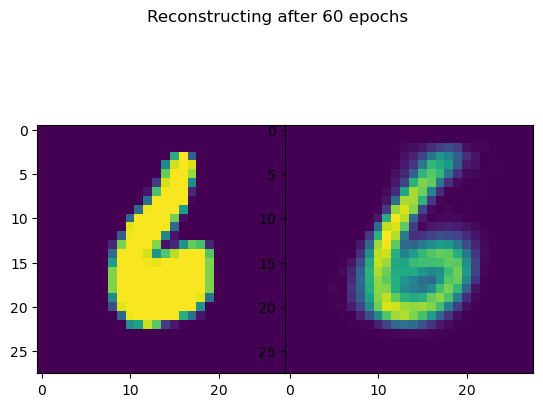

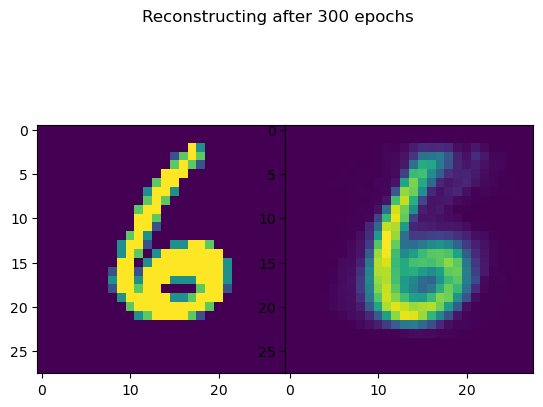

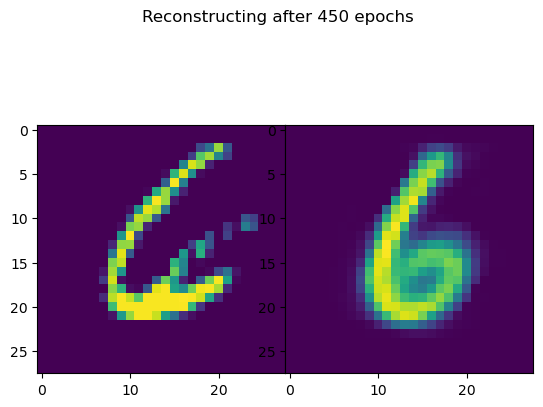

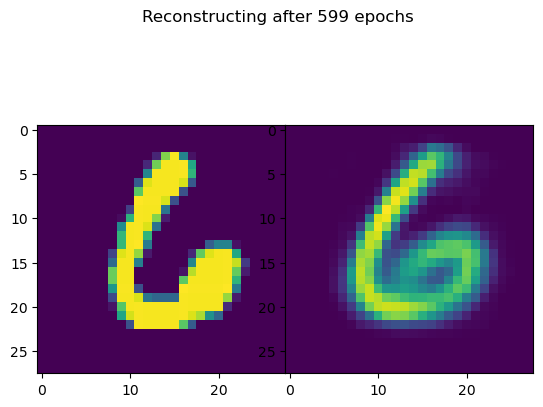

Finished Training


In [119]:
def plot_reconstructions(image, reconstruction, epoch):
    #plot the original image and the reconstructed one
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle("Reconstructing after "+str(epoch)+" epochs")
    ax1.imshow(image[0].reshape(28,28).cpu())
    ax2.imshow(reconstruction[0].reshape(28,28).cpu().detach().numpy())
    plt.subplots_adjust(top=0.85, wspace=0, hspace=0)
    plt.show()



model = None #make sure to remove any version of the model that exists in memory
model = AE().to(device) #casting to model GPU, if GPU is available

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss() #deciding which loss function to use for the training
 
# Using an Adam Optimizer with learning rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1, weight_decay = 1e-8)

print("Built NN, beginning training process")

epochs = 600
outputs = []
losses = []
epochs_to_plot = [math.floor(epochs/10), 
                  math.floor(epochs/2), 
                  math.floor(0.75*epochs), 
                  epochs-1] # let's plot how the reconstruction approaches the correct answer over the course of the training period

for epoch in range(epochs):
    for (image, y) in loader:
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28).to(device)
        
        optimizer.zero_grad()
        # Output of Autoencoder
        reconstructed = model(image)
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss)
        if epoch == epochs-1:
            outputs.append(reconstructed)
    if epoch in epochs_to_plot or epoch == epochs-1:
        plot_reconstructions(image, reconstructed, epoch)
        
print("Finished Training")

We've trained our network! Specifically, we trained our network to recognize a handwritten 6 and realize that it is a '6'.  Let's save this model so it can be reused, and see how we can reload it from file once saved.

In [121]:
torch.save(model.state_dict(), "Trained Model.pt") #saving the model


six_model = AE()
six_model.load_state_dict(torch.load("Trained Model.pt", map_location = torch.device("cpu")))
six_model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=18, bias=True)
    (3): ReLU()
    (4): Linear(in_features=18, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=18, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=18, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

## A Fun Note

Recall that we used a latent space with size equal to 1. This means this latent space is made of one number that measures the "six-ness" of each image. Because we divided our autoencoder into an encoder and a decoder, if we use the latent space in combination with our decoder, we have a "six generator", where we can feed in a "six-ness" and generate a six with that "six-ness". In general, the more complicated our network is, and the longer we train for, the more detailed this measure of "six-ness" can become. Let's explore the different kinds of sixes we can create with our network: 

In [128]:
six_ness = np.asarray([2.0], dtype = float)

six_model.decoder(torch.from_numpy(six_ness))

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float